# Describe a PIV evaluation using openPIV

[OpenPIV](https://github.com/OpenPIV/openpiv-python) is an open-source PIV software. Let's use it to process the PIV-Challenge recording. Of course, you should have installed for this tutorial 

## Get image filenames from JSON-LD

In [1]:
import pivmetalib
from pivmetalib import pivmeta

**extract zip files**

In [2]:
image_dists = pivmetalib.query(pivmeta.PivImageDistribution, source='piv_challenge.jsonld')
image_dist = image_dists[0]

In [3]:
image_dir = image_dist.download_and_unpack('imgs')
image_dir

'imgs'

retrieve filenames:

In [4]:
filenames = image_dist.get_filenames(image_dir)

In [5]:
mask_dists = pivmetalib.query(pivmeta.PivMaskDistribution, source='piv_challenge.jsonld')
mask_dist = mask_dists[0]

In [6]:
mask_filename = mask_dist.get_filenames(image_dir)[0]
mask_filename

WindowsPath('imgs/Cmask_1.tif')

## Perform evaluation with OpenPIV

In [7]:
import openpiv
from openpiv import tools, pyprocess, validation, filters, scaling

openpiv.__version__

'0.26.0a0'

We'll be re-using code from [openpiv's tutorial 1](https://nbviewer.org/github/OpenPIV/openpiv-python-examples/blob/main/notebooks/tutorial1.ipynb):

In [8]:
import cv2
import numpy as np

frame_a = cv2.imread(str(filenames[0]), -1)
frame_b = cv2.imread(str(filenames[1]), -1)

# mask images
image_mask = cv2.imread(str(mask_filename), -1)
frame_a_masked = np.where(image_mask, frame_a, 0)
frame_b_masked = np.where(image_mask, frame_b, 0)

In [9]:
mask_filename

WindowsPath('imgs/Cmask_1.tif')

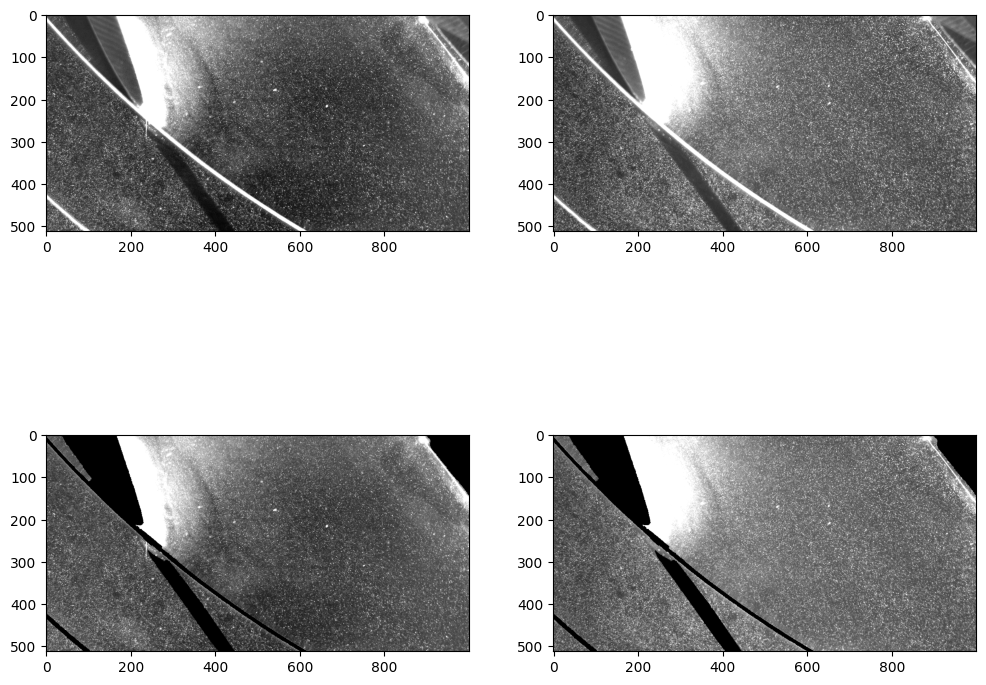

In [10]:
import matplotlib.pyplot as plt

fig, _axs = plt.subplots(2,2,figsize=(12,10))
axs = _axs.ravel()
axs[0].imshow(frame_a,cmap=plt.cm.gray)
axs[1].imshow(frame_b,cmap=plt.cm.gray)
axs[2].imshow(frame_a_masked, cmap=plt.cm.gray)
axs[3].imshow(frame_b_masked, cmap=plt.cm.gray)

In [11]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 1 # sec, arbitrary here as we have no information

u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')



In [12]:
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [13]:
flags = validation.sig2noise_val( sig2noise, 
                                 threshold = 1.05 )

In [14]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u0, v0, 
                                   flags,
                                   method='localmean', 
                                   max_iter=3, 
                                   kernel_size=3)

In [15]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 1 ) # 1 microns/pixel (arbitrary, no info)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [16]:
#save in the simple ASCII table format
tools.save('exp1_001.txt', x, y, u3, v3, flags=flags)

WindowsPath('exp1_001.txt')

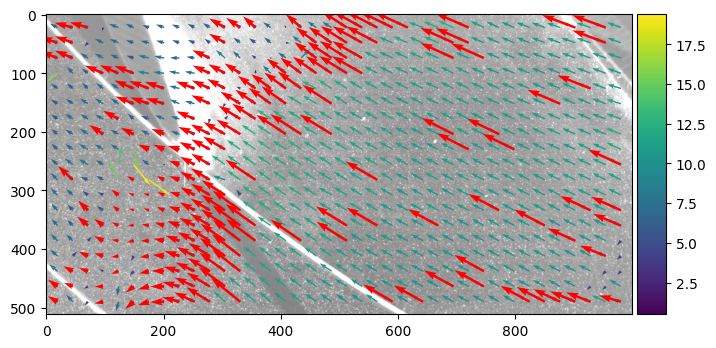

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(frame_a,cmap=plt.cm.gray, alpha=0.5)

v_abs = np.sqrt(u3**2+v3**2)

plt.rcParams['image.cmap'] = 'viridis'

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

q = ax.quiver(x, y, u3, v3, v_abs)
ax.quiver(x[flags], y[flags], u3[flags], v3[flags], color='r', label='invalid')
plt.colorbar(q, cax=cax)

## Describe the result file

First of all we need to describe the software that was used:

In [18]:
from pivmetalib import prov

from pprint import pprint

In [19]:
software = pivmeta.PIVSoftware(
    author=prov.Organisation(
        name='OpenPIV',
        url='https://github.com/OpenPIV/openpiv-python',
    ),
    description='OpenPIV is an open source Particle Image Velocimetry analysis software written in Python and Cython',
    softwareVersion=openpiv.__version__,
    has_documentation='https://openpiv.readthedocs.io/en/latest/',
)
pprint(software.model_dump(exclude_none=True))

{'author': {'name': 'OpenPIV',
            'url': Url('https://github.com/OpenPIV/openpiv-python')},
 'description': 'OpenPIV is an open source Particle Image Velocimetry analysis '
                'software written in Python and Cython',
 'has_documentation': Url('https://openpiv.readthedocs.io/en/latest/'),
 'softwareVersion': '0.26.0a0'}


In [20]:
import pathlib
result_distribution = pivmeta.PivResultDistribution(
    downloadURL=pathlib.Path('exp1_001.txt')
)

In [21]:
from h5rdmtoolbox.namespace import M4I

In [22]:
M4I.Researcher

rdflib.term.URIRef('http://w3id.org/nfdi4ing/metadata4ing#Researcher')

In [23]:
from pivmetalib import dcat, m4i
import rdflib

result_dataset = dcat.Dataset(
    distribution=result_distribution,
    hadRole=prov.Person(firstName='Matthias',
                        role=M4I.Researcher)
)
print(result_dataset.dump_jsonld())

{
    "@context": {
        "@import": "https://raw.githubusercontent.com/matthiasprobst/pivmeta/main/pivmeta_context.jsonld"
    },
    "@graph": [
        {
            "@id": "https://local-domain.org/7e4a7571-747f-462e-8e1c-315ae3f4a8e5",
            "@type": "dataset",
            "hadRole": {
                "@id": "https://local-domain.org/05f221ec-00f7-4ad7-a504-99e508a18030"
            },
            "hat Verteilung": {
                "@id": "https://local-domain.org/450d1f1c-ba7a-4527-8ed5-500d50e96abe"
            }
        },
        {
            "@id": "https://local-domain.org/450d1f1c-ba7a-4527-8ed5-500d50e96abe",
            "@type": "piv result distribution",
            "download URL": "file:///C:/Users/da4323/Documents/programming/git/pivmetalib/docs/exp1_001.txt"
        },
        {
            "@id": "https://local-domain.org/05f221ec-00f7-4ad7-a504-99e508a18030",
            "@type": "person",
            "Rolle des Akteurs": "http://w3id.org/nfdi4ing/metadata

In [24]:
from pivmetalib.decorator import NamespaceManager, URIRefManager

In [25]:
M4I.hadRole

C:\Users\da4323\AppData\Local\Temp\ipykernel_19132\403143510.py:1: UserWarning: Code: hadRole is not defined in namespace M4I
  M4I.hadRole


rdflib.term.URIRef('http://w3id.org/nfdi4ing/metadata4ing#hadRole')

In [26]:
URIRefManager[result_dataset.__class__]['contact'] = M4I.hadRole

In [27]:
URIRefManager[result_dataset.__class__]

{'Thing': 'owl:Thing',
 'label': 'rdfs:label',
 'Resource': 'dcat:Resource',
 'title': 'dct:title',
 'description': 'dct:description',
 'creator': 'dct:creator',
 'version': 'dcat:version',
 'Dataset': 'dcat:Dataset',
 'identifier': 'dct:identifier',
 'distribution': 'dcat:distribution',
 'modified': 'dct:modified',
 'landingPage': 'dcat:landingPage',
 'contact': rdflib.term.URIRef('http://w3id.org/nfdi4ing/metadata4ing#hadRole')}

In [28]:
pivmetalib.get_iri_fields(result_dataset)

{'Thing': 'http://www.w3.org/2002/07/owl#Thing',
 'label': 'http://www.w3.org/2000/01/rdf-schema#label',
 'Resource': 'http://www.w3.org/ns/dcat#Resource',
 'title': 'http://purl.org/dc/terms/title',
 'description': 'http://purl.org/dc/terms/description',
 'creator': 'http://purl.org/dc/terms/creator',
 'version': 'http://www.w3.org/ns/dcat#version',
 'Dataset': 'http://www.w3.org/ns/dcat#Dataset',
 'identifier': 'http://purl.org/dc/terms/identifier',
 'distribution': 'http://www.w3.org/ns/dcat#distribution',
 'modified': 'http://purl.org/dc/terms/modified',
 'landingPage': 'http://www.w3.org/ns/dcat#landingPage',
 'contact': rdflib.term.URIRef('http://w3id.org/nfdi4ing/metadata4ing#hadRole')}